<div style="text-align: center; color:royalblue;">
    <h1>Project: Prediction of Natural Disaster Intensity in the United States 💥</h1>
    <h3>Using Hailstorm and Thunderstorm Wind data</h3>
    <h3 style="color:green;">Data history: 2006, 2018 - 2021</h3>
</div>

## Libraries

In [267]:
# Data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Statistics
from scipy.stats import chi2_contingency

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from scipy.stats import loguniform
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

## Configurations

In [105]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [106]:

base = "./Data/"
files = ["StormEvents_details-database_v1.0_d2006_c20210603",
"StormEvents_details-database_v1.0_d2018_c20210604",
"StormEvents_details-database_v1.0_d2019_c20210604",
"StormEvents_details-database_v1.0_d2020_c20210604",
"StormEvents_details-database_v1.0_d2021_c20210607"]

df_og = pd.concat([pd.read_csv(f"{base}{file}.csv") for file in files])
df_og.head()

C:\Users\RITISH\AppData\Local\Temp\ipykernel_19704\1814866143.py:9: DtypeWarning: Columns (29,34,35,37,48,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_og = pd.concat([pd.read_csv(f"{base}{file}.csv") for file in files])


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_TITLE,EPISODE_NARRATIVE,EVENT_NARRATIVE,LAST_MOD_DATE,LAST_MOD_TIME,LAST_CERT_DATE,LAST_CERT_TIME,LAST_MOD,LAST_CERT,ADDCORR_FLG,ADDCORR_DATE,DATA_SOURCE
0,200604,7,1515,200604,7,1515,1207534,5501658,INDIANA,18,2006,April,Thunderstorm Wind,C,51,GIBSON,PAH,07-APR-06 15:15:00,CST,07-APR-06 15:15:00,0,0,0,0,60K,NaN,GENERAL PUBLIC,61.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,E,PATOKA,NaN,NaN,OAKLAND CITY,38.42,-87.52,38.33,-87.35,NaN,NaN,"At Wheeling, the windows were blown out of a c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS
1,200601,1,0,200601,31,2359,1202408,5482463,COLORADO,8,2006,January,Drought,Z,2,CENTRAL YAMPA RIVER BASIN,GJT,01-JAN-06 00:00:00,MST,31-JAN-06 23:59:00,0,0,0,0,NaN,NaN,GOVT OFFICIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The storm track favored northwest Colorado wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS
2,200601,1,0,200601,31,2359,1202408,5482464,COLORADO,8,2006,January,Drought,Z,7,DEBEQUE TO SILT CORRIDOR,GJT,01-JAN-06 00:00:00,MST,31-JAN-06 23:59:00,0,0,0,0,NaN,NaN,GOVT OFFICIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The storm track favored northwest Colorado wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS
3,200601,1,0,200601,31,2359,1202408,5482465,COLORADO,8,2006,January,Drought,Z,4,ELKHEAD AND PARK MOUNTAINS,GJT,01-JAN-06 00:00:00,MST,31-JAN-06 23:59:00,0,0,0,0,NaN,NaN,GOVT OFFICIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The storm track favored northwest Colorado wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS
4,200601,1,0,200601,31,2359,1202408,5482466,COLORADO,8,2006,January,Drought,Z,13,FLATTOP MOUNTAINS,GJT,01-JAN-06 00:00:00,MST,31-JAN-06 23:59:00,0,0,0,0,NaN,NaN,GOVT OFFICIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The storm track favored northwest Colorado wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS


## Functions created

In [107]:
def df_metrics(df):
    '''
Cette fonction renvoi:
Le taux de valeurs non-nulles par variable
Le nombre de valeurs non-nulles par variable
Le taux de valeurs par variable
    '''
    fill_rate = df.notna().mean() * 100 
    num_values = df.count()
    na_rate = df.isna().mean() * 100 

    metrics_df = pd.DataFrame({
        'Fill Rate (%)': fill_rate,
        'Number of Values': num_values,
        'NA Rate (%)': na_rate
    }).sort_values(by =["Fill Rate (%)"], ascending=False)
    return metrics_df

In [108]:
def impute_columns(df, columns, group_by):
    for column in columns:
        if df[column].dtype == 'object':  
            df[column] = df.groupby(group_by, as_index=False)[column].apply(lambda x: x.fillna(x.mode()[0])).droplevel([0])
        else: 
            df[column] = df.groupby(group_by, as_index=False)[column].apply(lambda x: x.fillna(x.median())).droplevel([0])
    return df

In [109]:
def classify_magnitude(row): # Creating our target variable
    """
    Classifies MAGNITUDE INTENSITY based on EVENT_TYPE and MAGNITUDE values.

    - Hail:
      - > 2 inches → 2 (High)
      - 1 - 2 inches → 1 (Moderate)
      - < 1 inch → 0 (Low)
    
    - Thunderstorm Wind:
      - > 75 mph → 2 (High)
      - 50 - 75 mph → 1 (Moderate)
      - < 50 mph → 0 (Low)
    """
    if row['EVENT_TYPE'] == 'Hail':
        if row['MAGNITUDE'] > 2:
            return 2  # Élevée
        elif row['MAGNITUDE'] >= 1:
            return 1  # Modérée
        elif row['MAGNITUDE'] < 1:
            return 0  # Faible

    elif row['EVENT_TYPE'] == 'Thunderstorm Wind':
        if row['MAGNITUDE'] > 75:
            return 2  # Élevée
        elif 50 <= row['MAGNITUDE'] <= 75:
            return 1  # Modérée
        elif row['MAGNITUDE'] < 50:
            return 0  # Faible

    return None  # If EVENT_TYPE is not recognized

In [110]:
def cramers_v(var1, var2):
    # Create a contingency table
    contingency_table = pd.crosstab(var1, var2)
    
    # Perform Chi-Square test
    chi2, _, _, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()  # Total observations
    r, k = contingency_table.shape  # Rows and columns
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

In [111]:
def cramers_v_matrix(df):
    # Get categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    corr_matrix = corr_matrix.astype(float)
    return corr_matrix

In [ ]:
def pearson_corr_matrix(df):
    
    numerical_cols = df.select_dtypes(include=['number']).columns
    corr_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True,
                linewidths=0.5, annot_kws={"size": 10}, vmin=-1, vmax=1)
    
    plt.title("Pearson's Correlation Matrix for Numerical Variables")
    plt.show()
    return None

In [232]:
def evaluate_multiclass_model(y_test, y_pred, y_proba=None, class_labels=None):
    """
    Evaluate the performance of a multi-class classification model and return metrics with a classification matrix.

    Parameters:
    - y_test: Ground truth labels (true values).
    - y_pred: Predicted labels by the model.
    - y_proba: Predicted probabilities for each class (for multi-class ROC-AUC).
    - class_labels: List of class labels for better labeling in the confusion matrix (default: None).

    Returns:
    - A Pandas DataFrame with evaluation metrics.
    - Displays a heatmap of the confusion matrix.
    """
    
    # Metrics for multi-class classification
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Macro)": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Recall (Macro)": recall_score(y_test, y_pred, average='macro', zero_division=0),
        "F1 Score (Macro)": f1_score(y_test, y_pred, average='macro', zero_division=0),
        "Precision (Weighted)": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall (Weighted)": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score (Weighted)": f1_score(y_test, y_pred, average='weighted', zero_division=0),
    }
    
    # Add ROC-AUC score if probabilities are provided
    if y_proba is not None:
        metrics["ROC-AUC (Macro)"] = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')  # One-vs-Rest
        metrics["ROC-AUC (Weighted)"] = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')

    
    cm = confusion_matrix(y_test, y_pred)
    print("\nClassification Matrix (Confusion Matrix):")
    print(cm)

    # Display confusion matrix heatmap if class labels are provided
    if class_labels is not None:
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

    
    metrics_df = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
    
    return metrics_df

## Data Preparation
+ We see that we do not have sufficient data of `MAGNITUDE` for prediction. We will filter only `HAIL` and `THUNDERSTORM` type of natural disaster for the prediction.

In [112]:
df_og["EVENT_TYPE"].value_counts()

EVENT_TYPE
Thunderstorm Wind             66580
Hail                          41282
Winter Weather                15572
Flash Flood                   14789
High Wind                     14400
Flood                         13945
Winter Storm                  12905
Heavy Snow                     9679
Drought                        9065
Marine Thunderstorm Wind       8683
Heavy Rain                     5688
Tornado                        5521
Heat                           5358
Strong Wind                    5169
Dense Fog                      3243
Frost/Freeze                   2740
Extreme Cold/Wind Chill        2659
Blizzard                       2483
Cold/Wind Chill                2110
Excessive Heat                 2077
High Surf                      1997
Lightning                      1833
Wildfire                       1444
Funnel Cloud                   1333
Tropical Storm                 1322
Ice Storm                      1073
Coastal Flood                  1010
Waterspout       

In [145]:
df = df_og.loc[df_og["EVENT_TYPE"].isin(["Thunderstorm Wind", "Hail"])].reset_index(drop = True)

#### Descriptive Statistics of Columns (A)

In [146]:
metrics = df_metrics(df)
metrics.sort_values(by = 'NA Rate (%)', ascending = False)

,Fill Rate (%),Number of Values,NA Rate (%)
TOR_F_SCALE,0.000000,0,100.000000
CATEGORY,0.000000,0,100.000000
TOR_OTHER_CZ_FIPS,0.000000,0,100.000000
TOR_OTHER_CZ_NAME,0.000000,0,100.000000
TOR_OTHER_CZ_STATE,0.000000,0,100.000000
TOR_OTHER_WFO,0.000000,0,100.000000
TOR_WIDTH,0.000000,0,100.000000
TOR_LENGTH,0.000000,0,100.000000
FLOOD_CAUSE,0.000000,0,100.000000
ADDCORR_FLG,19.141125,20646,80.858875


#### Dropping the following columns
+ Values with Null rate >80%:
   `CATEGORY, TOR_OTHER_WFO, TOR_OTHER_CZ_STATE, TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME, TOR_WIDTH, TOR_LENGTH, TOR_F_SCALE,FLOOD_CAUSE, ADDCORR_FLG, ADDCORR_DATE`
+ Values dropped representing future events representing the results of magnitude intensity: `DAMAGE_CROPS, DAMAGE_PROPERTY, DEATHS_INDIRECT, DEATHS_DIRECT, INJURIES_INDIRECT, INJURIES_DIRECT`

+ Values not required: `LAST_MOD, MAGNITUDE_TYPE, EVENT_NARRATIVE, EPISODE_TITLE, LAST_MOD_TIME, LAST_CERT_DATE, LAST_CERT_TIME, LAST_CERT, LAST_MOD_DATE, EPISODE_NARRATIVE, BEGIN_DAY, SOURCE, DATA_SOURCE, END_DAY, YEAR, EVENT_ID, END_YEARMONTH, EPISODE_ID, END_TIME, BEGIN_TIME, BEGIN_YEARMONTH`	



In [147]:
cols_dropped = ["EPISODE_ID",
                "EVENT_ID",
                  "EPISODE_NARRATIVE",
                  "CATEGORY",
                  "TOR_OTHER_CZ_NAME",
                  "TOR_OTHER_CZ_FIPS",
                  "TOR_OTHER_CZ_STATE",
                  "TOR_OTHER_WFO",
                  "TOR_LENGTH",
                  "TOR_WIDTH",
                  "TOR_F_SCALE",
                  "FLOOD_CAUSE",
                  "DAMAGE_PROPERTY",
                  "LAST_CERT",
                  "EVENT_NARRATIVE",
                  "LAST_CERT_TIME",
                  "LAST_CERT_DATE",
                  "LAST_MOD",
                  "ADDCORR_DATE",
                  "ADDCORR_FLG",
                  "DAMAGE_CROPS",
                  "MAGNITUDE_TYPE",
                  "LAST_MOD_DATE",
                  "EPISODE_TITLE",
                  "LAST_MOD_TIME",
                  "DATA_SOURCE",
                  "SOURCE",
                  "INJURIES_DIRECT",
                  "INJURIES_INDIRECT",
                  "DEATHS_DIRECT",
                  "DEATHS_INDIRECT",
                  "YEAR",
                  "BEGIN_DAY",
                  "BEGIN_TIME",
                  "BEGIN_YEARMONTH",
                  "END_DAY",
                  "END_TIME",
                  "END_YEARMONTH",
                  "BEGIN_LON",
                  "BEGIN_LAT",
                  "END_LON",
                  "END_LAT"
                  ]

In [148]:
df = df.drop(cols_dropped, axis=1)

In [149]:
print("New shape of data:\n" f"{df.shape}", "\nRemaining Columns:\n" f"{df.columns}")

New shape of data:
(107862, 18) 
Remaining Columns:
Index(['STATE', 'STATE_FIPS', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS',
       'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'MAGNITUDE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_RANGE', 'END_AZIMUTH', 'END_LOCATION'],
      dtype='object')


#### Descriptive Statistics of Columns (B)

In [150]:
df_metrics(df)

,Fill Rate (%),Number of Values,NA Rate (%)
STATE,100.000000,107862,0.000000
STATE_FIPS,100.000000,107862,0.000000
MONTH_NAME,100.000000,107862,0.000000
EVENT_TYPE,100.000000,107862,0.000000
CZ_TYPE,100.000000,107862,0.000000
CZ_FIPS,100.000000,107862,0.000000
CZ_NAME,100.000000,107862,0.000000
WFO,100.000000,107862,0.000000
BEGIN_DATE_TIME,100.000000,107862,0.000000
CZ_TIMEZONE,100.000000,107862,0.000000


#### Imputation of missing values
+ `BEGIN_AZIMUTH, END_AZIMUTH, BEGIN_RANGE, END_RANGE` are the values that needs to be handled.
+ `BEGIN_RANGE` and `END_RANGE` imputed using the median grouped by `STATE` and `EVENT_TYPE`.
+ `BEGIN_AZIMUTH` and `END_AZIMUTH` are imputed using the most frequent direction (Mode) by `STATE` and `EVENT_TYPE`.

In [151]:
columns_to_impute = ['BEGIN_RANGE', 'END_RANGE', 'BEGIN_AZIMUTH', 'END_AZIMUTH']
group_by = ['STATE', 'EVENT_TYPE']
df = impute_columns(df, columns_to_impute, group_by)

#### Converting the date time to EST time zone

In [152]:
df["CZ_TIMEZONE"].value_counts()

CZ_TIMEZONE
CST-6     38693
EST-5     30197
CST       16376
EST       10561
MST-7      9111
MST        2092
PST-8       501
PST         294
AST-4        17
AST           9
AKST-9        4
HST           3
HST-10        3
GST10         1
Name: count, dtype: int64

In [153]:
def convert_to_utc(row, column):
    local_tz = pytz.timezone(timezone_mapping[row['CZ_TIMEZONE']])
    local_time = pd.Timestamp(row[column]).tz_localize(local_tz)
    return local_time.astimezone(pytz.utc)

#### Descriptive Statistics of Columns (C) - After imputation

In [154]:
df_metrics(df)

,Fill Rate (%),Number of Values,NA Rate (%)
STATE,100.0,107862,0.0
STATE_FIPS,100.0,107862,0.0
MONTH_NAME,100.0,107862,0.0
EVENT_TYPE,100.0,107862,0.0
CZ_TYPE,100.0,107862,0.0
CZ_FIPS,100.0,107862,0.0
CZ_NAME,100.0,107862,0.0
WFO,100.0,107862,0.0
BEGIN_DATE_TIME,100.0,107862,0.0
CZ_TIMEZONE,100.0,107862,0.0


#### Data insights
+ North Dakota,Kansas and Montana are the 3 states that are hit with the strongest damages of Hail and WeatherStorm
+ Puerto Rico, Hawaii, Guam are the 3 states that are hit with the lowest intensity of damages in average magnitude

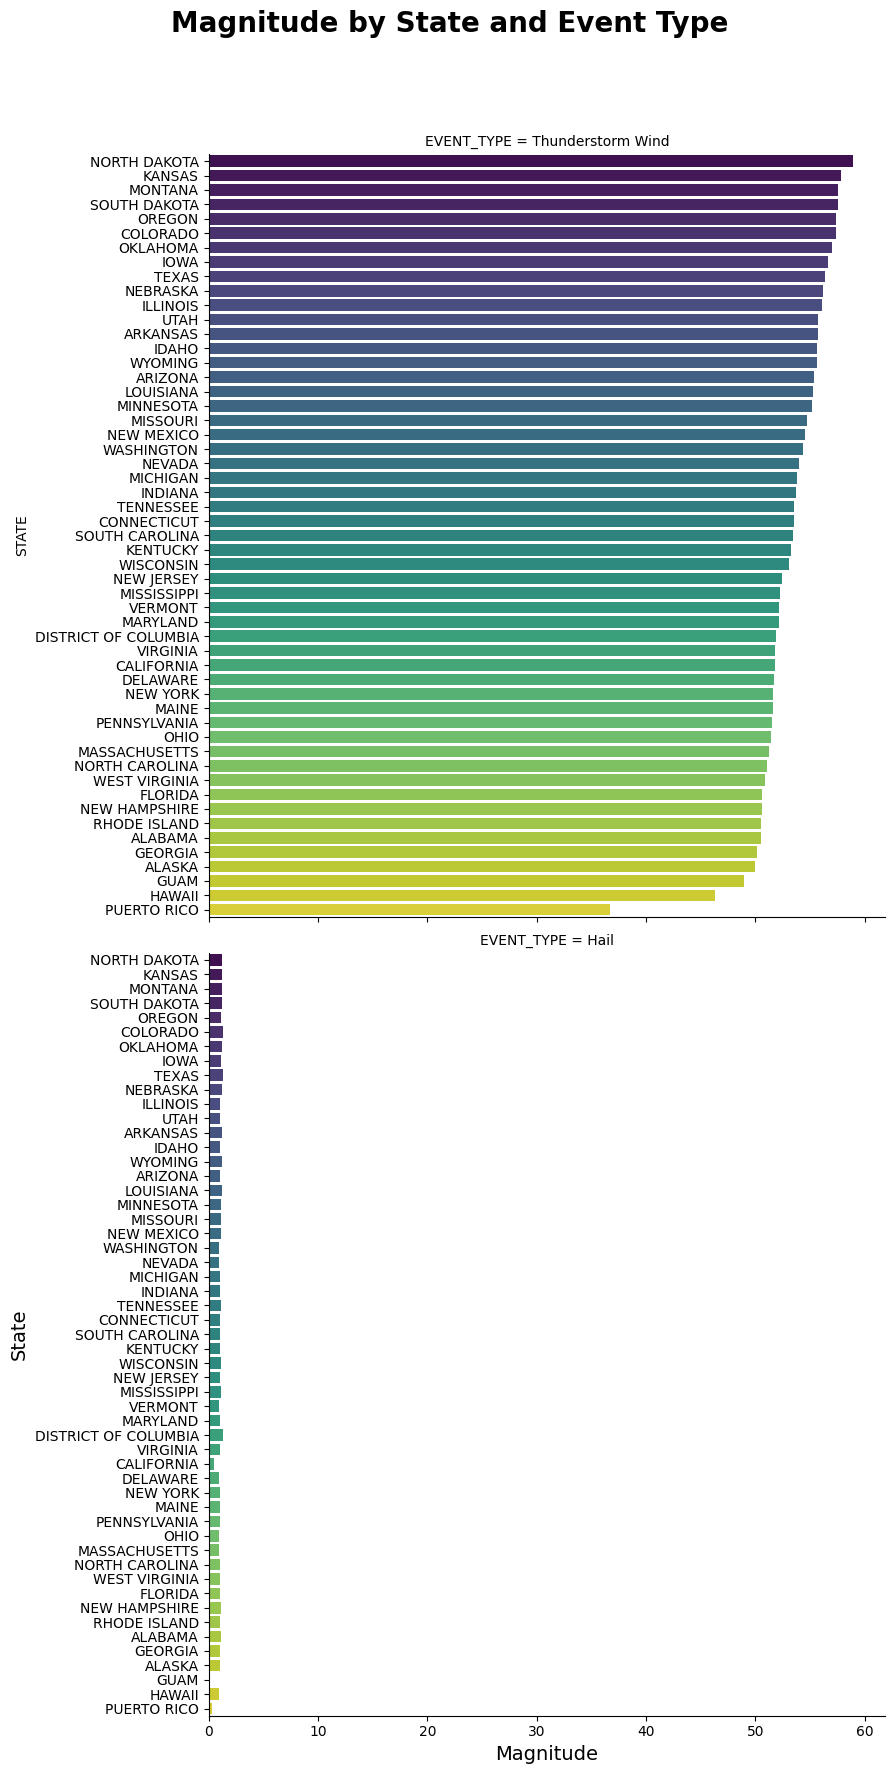

In [155]:
sorted_data = df.groupby(['EVENT_TYPE', 'STATE'], as_index=False)['MAGNITUDE'].mean().sort_values(by = "MAGNITUDE", ascending=False)
sns.catplot(
    data=sorted_data,
    y="STATE",
    hue="STATE",
    x="MAGNITUDE",           
    col="EVENT_TYPE",        
    kind="bar",             
    height=9,               
    aspect=1,             
    palette="viridis",       
    errorbar=None,
    legend = False,
    col_wrap=1
)
plt.subplots_adjust(top=0.9)  
plt.suptitle("Magnitude by State and Event Type", fontsize=20, fontweight='bold')
plt.xlabel("Magnitude", fontsize=14)
plt.ylabel("State", fontsize=14)
plt.show()

#### Feature Engineering
+ We create columns that represents more useful data injected in our Machine Learning algorithms.

In [156]:
df["BEGIN_DATE_TIME"] = pd.to_datetime(df["BEGIN_DATE_TIME"], format='%d-%b-%y %H:%M:%S')
df["END_DATE_TIME"] = pd.to_datetime(df["END_DATE_TIME"], format='%d-%b-%y %H:%M:%S')

In [157]:
# df["DISASTER_DURATION"] = (df["END_DATE_TIME"] - df["BEGIN_DATE_TIME"]).dt.total_seconds() / 3600 # Extracting hours

#### Mapping Each Month to Its Corresponding Season
+ We map the corresponding months to the seasons in the United States

In [158]:
season_mapping = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}

df['SEASONS'] = df['MONTH_NAME'].map(season_mapping)

#### Dropping additional columns not suitable for machine learning

In [159]:
cols_dropped_2 = ['MONTH_NAME', 
                'END_LOCATION',
                'BEGIN_LOCATION',
                'END_DATE_TIME',
                'CZ_TIMEZONE',
                'CZ_TYPE',
                'MONTH_NAME',
                'BEGIN_DATE_TIME',
                ]

Additional columns one may want to drop or not

In [160]:
df = df.drop(cols_dropped_2, axis=1)

#### Creation of the target variable: Assigning numerical intensity levels based on event type and magnitude

``` Hail:```
  - 2 inches: 2 (High)
  - 1 - 2 inches: 1 (Moderate)
  - 1 inch: 0 (Low)

      
``` Thunderstorm Wind:```
   - greater than 75 mph: 2 (High)
   - between 50 - 75 mph: 1 (Moderate)
   - less than 50 mph: 0 (Low)
   

+  We use the function we created to classify the magnitude to create the target variable

In [161]:
df['MAGNITUDE INTENSITY'] = df.apply(classify_magnitude, axis=1) 

In [162]:
df.drop(columns=['MAGNITUDE'], inplace=True) # We drop the magnitude column

#### To save data to csv format if needed.

In [163]:
#df.to_csv("storm_data_cleaned.csv")

#### Class balance of target variable check

In [176]:
data = df.copy() 

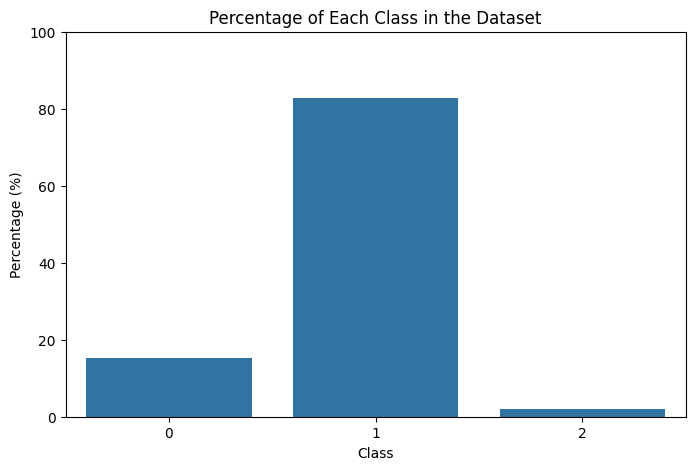

MAGNITUDE INTENSITY
1    82.763160
0    15.123955
2     2.112885
Name: proportion, dtype: float64


In [177]:
class_counts = data["MAGNITUDE INTENSITY"].value_counts(normalize=True) * 100 
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Percentage of Each Class in the Dataset")
plt.ylim(0, 100)
plt.show()
print(class_counts.sort_values(ascending = False))

In [236]:
data["MAGNITUDE INTENSITY"].value_counts()

MAGNITUDE INTENSITY
1    89270
0    16313
2     2279
Name: count, dtype: int64

### Correlation matrix

In [178]:
data["MAGNITUDE INTENSITY"] = data["MAGNITUDE INTENSITY"].astype(str)

#### Cramer's V to test association strength for categorical variables

- **0.00 - 0.10**: Very weak or negligible association.
- **0.10 - 0.20**: Weak association.
- **0.20 - 0.30**: Moderate association.
- **0.30 - 0.50**: Strong association.
- **Above 0.50**: Very strong association.

```We will drop the variables having a value > 0.30 for this study.```
> Source: The Encyclopedia of Statistical Sciences (Wiley-Interscience) or other academic books like Applied Multivariate Statistical Analysis by Johnson and Wichern typically explain association

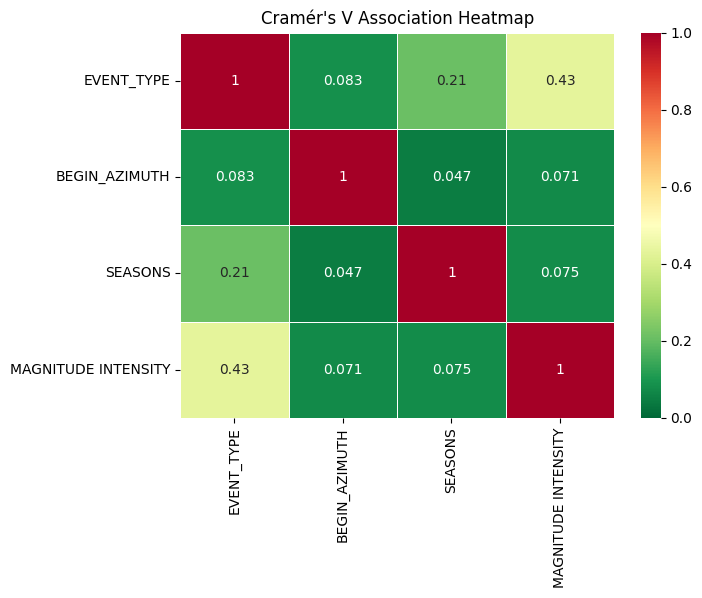

In [183]:
corr_matrix = cramers_v_matrix(data) # We use the created function
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn_r', cbar=True, 
            linewidths=0.5, annot_kws={"size": 10},
            vmin=0, vmax=1, center=0.5)
plt.title("Cramér's V Association Heatmap")
plt.show()

#### Dropping variables having strong association
+ We drop ```CZ_NAME, END_AZIMUTH, STATE, WFO``` and keep ```EVENT_TYPE``` which has a stronger correlation with our target variable.

In [180]:
data.drop(columns=['CZ_NAME', 'END_AZIMUTH', 'STATE', 'WFO'], inplace=True)

#### Pearson's Correlation matrix for numerical variables
* Ranges
    - **-0.0 to -0.2**: Very weak or no negative correlation.
    - **-0.2 to -0.4**: Weak negative correlation.
    - **-0.4 to -0.6**: Moderate negative correlation.
    - **-0.6 to -0.8**: Strong negative correlation.
    - **-0.8 to -1.0**: Very strong negative correlation.
    
    - **0.0 to 0.2**: Very weak or no positive correlation.
    - **0.2 to 0.4**: Weak positive correlation.
    - **0.4 to 0.6**: Moderate positive correlation.
    - **0.6 to 0.8**: Strong positive correlation.
    - **0.8 to 1.0**: Very strong positive correlation.




We will drop variables having a correlation coefficient > 0.80 in this study.
> Source: Data Science Handbook: Feature Engineering for Machine Learning by Alice Zheng and Amanda Casari (O'Reilly Media, 2018)

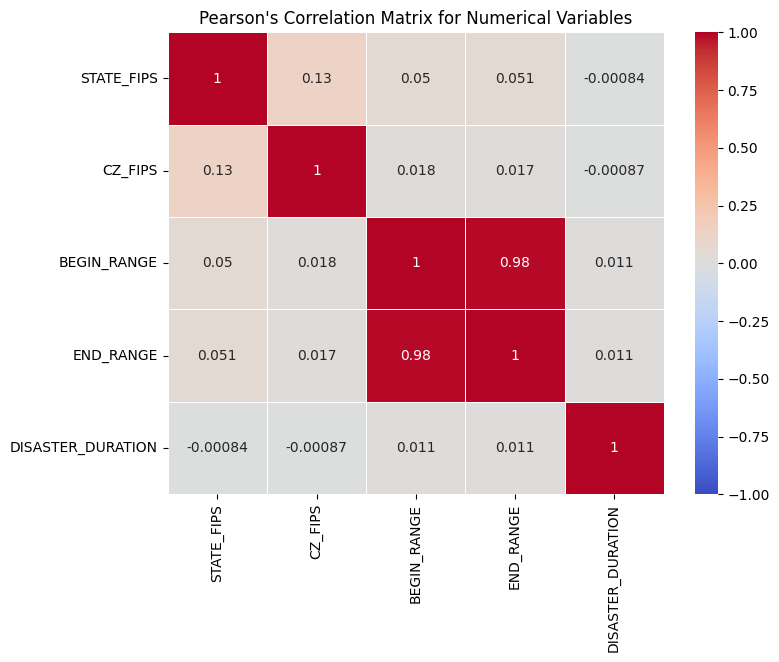

In [185]:
pearson_corr_matrix(data)

#### Dropping correlated variables
+ We drop the ```END_RANGE``` variable.
+ We drop the created variable ```DISASTER_DURATION``` due to fact tha the data will be available after the natural disaster.

In [186]:
data.drop(columns=['END_RANGE', 'DISASTER_DURATION'], inplace=True)

### Machine Learning

In [203]:
def get_splits(data):
    data_c = data.copy()
    X = data_c.drop("MAGNITUDE INTENSITY", axis=1)
    y = data_c["MAGNITUDE INTENSITY"]
    splits = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return splits

In [201]:
X_train, X_test, y_train, y_test = get_splits(data)

#### Dummy Classifier model for benchmark

In [210]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)

print(f"Dummy accuracy: {accuracy_score(y_test, dummy_preds)}")
print(f"Dummy f1 score: {f1_score(y_test, dummy_preds, average='macro')}") # Compute f1 score per class then average equally

Dummy accuracy: 0.8276085848050804
Dummy f1 score: 0.30189125895114177


#### RandomForest Classifier

In [220]:
one_hot_cols = ["EVENT_TYPE","BEGIN_AZIMUTH","SEASONS"]

In [221]:
one_hot_pipeline = Pipeline(steps=[
    ("encoderOH", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(transformers=[
    ("encodeOH", one_hot_pipeline, one_hot_cols)
])

##### First RFC benchmark

In [222]:
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
])
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = ["accuracy", "f1_macro"]
cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")

In [227]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encodeOH',
                                                  Pipeline(steps=[('encoderOH',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EVENT_TYPE',
                                                   'BEGIN_AZIMUTH',
                                                   'SEASONS'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [228]:
y_pred_rfc = pipeline.predict(X_test) #Prediction
y_proba_rfc = pipeline.predict_proba(X_test) #Proba

##### Evaluation metrics for Random Forest Classifier

In [217]:
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean F1 Macro: {cv_results['test_f1_macro'].mean():.4f}")

Mean Accuracy: 0.6839
Mean F1 Macro: 0.4523


In [239]:
evaluate_multiclass_model(y_test,y_pred_rfc, y_proba_rfc)


Classification Matrix (Confusion Matrix):
[[ 1974   461   828]
 [ 3002 12707  2145]
 [  169   122   165]]


,Metric,Value
0,Accuracy,0.688175
1,Precision (Macro),0.464129
2,Recall (Macro),0.559508
3,F1 Score (Macro),0.459129
4,Precision (Weighted),0.850447
5,Recall (Weighted),0.688175
6,F1 Score (Weighted),0.748304
7,ROC-AUC (Macro),0.762644
8,ROC-AUC (Weighted),0.800977


##### Optuna for hyperparameter tuning

In [242]:
import optuna

C:\ProgramData\miniconda3\envs\Ritish_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [243]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20) 
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10) 

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, class_weight="balanced")

    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    scoring = ["accuracy", "f1_macro"]
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    accuracy = cv_results["test_accuracy"].mean()
    f1_macro = cv_results["test_f1_macro"].mean()

    return accuracy, f1_macro 

In [244]:
rfc_study = optuna.create_study(directions=["maximize", "maximize"])
rfc_study.optimize(objective, n_trials=10)

[I 2025-02-04 01:42:54,388] A new study created in memory with name: no-name-fae28a31-5a2f-4eb4-a3b6-c3f0e170dc94
[I 2025-02-04 01:43:05,358] Trial 0 finished with values: [0.684166000301313, 0.4528497769196032] and parameters: {'n_estimators': 226, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 9}.
[I 2025-02-04 01:43:13,580] Trial 1 finished with values: [0.7169395867375911, 0.445151691594127] and parameters: {'n_estimators': 274, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 3}.
[I 2025-02-04 01:43:29,338] Trial 2 finished with values: [0.6830766378101497, 0.45237203642690504] and parameters: {'n_estimators': 289, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9}.
[I 2025-02-04 01:43:37,189] Trial 3 finished with values: [0.6828912144073983, 0.45260697512386666] and parameters: {'n_estimators': 142, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 9}.
[I 2025-02-04 01:43:41,970] Trial 4 finished with values: [0.705559225393735, 

In [245]:
pareto_front = rfc_study.best_trials
for trial in pareto_front:
    print(f"Params: {trial.params}, Accuracy: {trial.values[0]:.4f}, F1 Macro: {trial.values[1]:.4f}")

Params: {'n_estimators': 274, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 3}, Accuracy: 0.7169, F1 Macro: 0.4452
Params: {'n_estimators': 224, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}, Accuracy: 0.7056, F1 Macro: 0.4556
Params: {'n_estimators': 95, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 2}, Accuracy: 0.7063, F1 Macro: 0.4547
Params: {'n_estimators': 131, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 9}, Accuracy: 0.7117, F1 Macro: 0.4529


Because we try to maximize two objective, we might endup with mulitple pairs where we can't improve one without decreasing the other

Here we have two best param sets, one which has a better Accuracy but slightly lower F1 score. 

We could design a better F1 Score, weighted by how dangerous being wrong on a type 2 vs being wrong on a type 0 is. 

Because of such imbalanced dataset, Accuracy is probably not the best metric to look at but we can see that our model can't do better than a DummyClassifier there, without sacrificing too much of the F1 score.

#### Logistic Regression

In [ ]:
# Encode categorical columns
le_event = LabelEncoder()
df['EVENT_TYPE'] = le_event.fit_transform(df['EVENT_TYPE'])

le_seasons = LabelEncoder()
df['SEASONS'] = le_seasons.fit_transform(df['SEASONS'])

# Select features and target
X = df[['STATE_FIPS', 'EVENT_TYPE', 'CZ_FIPS', 'DISASTER_DURATION', 'SEASONS']]
y = df['MAGNITUDE INTENSITY']

# Standardize the numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a broader search space for hyperparameter tuning
param_dist = {
    'C': loguniform(0.0001, 1000),  # Try a wider range of regularization strengths
    'solver': ['lbfgs', 'saga', 'saga'],  # Test different solvers
    'multi_class': ['ovr', 'multinomial']
}

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Perform RandomizedSearchCV to explore a broader range of hyperparameters
random_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, 
                                   n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Parameters Found: {best_params}')
print(f'Best Accuracy on Validation Set: {random_search.best_score_}')
print(f'Test Set Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

In [266]:
evaluate_multiclass_model(y_test, y_pred_logreg)


Classification Matrix (Confusion Matrix):
[[    0  3187     0]
 [    0 17901     0]
 [    0   485     0]]


,Metric,Value
0,Accuracy,0.829787
1,Precision (Macro),0.276596
2,Recall (Macro),0.333333
3,F1 Score (Macro),0.302326
4,Precision (Weighted),0.688547
5,Recall (Weighted),0.829787
6,F1 Score (Weighted),0.752598


#### Support Vector Machine (SVM)

In [276]:
one_hot_cols = ["EVENT_TYPE","BEGIN_AZIMUTH","SEASONS"]

In [277]:
one_hot_pipeline_svm = Pipeline(steps=[
    ("encoderOH", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor_svm = ColumnTransformer(transformers=[
    ("encodeOH", one_hot_pipeline, one_hot_cols)
])

In [279]:
pipeline_svm = Pipeline(steps=[
    ("preprocessing", preprocessor_svm),
    ("classifier", SVC(class_weight="balanced", random_state=42))  # adjust parameters as needed
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = ["accuracy", "f1_macro"]
cv_results = cross_validate(pipeline_svm, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")

In [280]:
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encodeOH',
                                                  Pipeline(steps=[('encoderOH',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EVENT_TYPE',
                                                   'BEGIN_AZIMUTH',
                                                   'SEASONS'])])),
                ('classifier', SVC(class_weight='balanced', random_state=42))])

In [282]:
y_pred_svm = pipeline_svm.predict(X_test) #Prediction

In [283]:
evaluate_multiclass_model(y_test, y_pred_svm)


Classification Matrix (Confusion Matrix):
[[ 1801   461  1001]
 [ 2627 12680  2547]
 [  147   121   188]]


,Metric,Value
0,Accuracy,0.679970
1,Precision (Macro),0.466699
2,Recall (Macro),0.558144
3,F1 Score (Macro),0.454755
4,Precision (Weighted),0.851896
5,Recall (Weighted),0.679970
6,F1 Score (Weighted),0.745919


## Re-training & Saving models

We save models to be used in our streamlit app. We need to re-train the models with the best-found hyperparameters on the ENTIRE set to be ready for inference. 

In [36]:
import joblib

### Best RFC

In [39]:
best_params = rfc_study.best_trials[0].params

In [41]:
best_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42,
    class_weight="balanced"
)

In [44]:
data_c = data.copy()
X = data_c.drop("MAGNITUDE INTENSITY", axis=1)
y = data_c["MAGNITUDE INTENSITY"]

pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", best_model)
])

pipeline.fit(X,y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encodeOH',
                                                  Pipeline(steps=[('encoderOH',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['EVENT_TYPE',
                                                   'BEGIN_AZIMUTH',
                                                   'SEASONS'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        min_samples_leaf=6,
                                        min_samples_split=12, n_estimators=200,
                                        random_state=42))])

In [45]:
joblib.dump(best_model, "RFC_best_pipeline.pkl")

['RFC_best_pipeline.pkl']